In [1]:
!pip install rouge-score bert-score bleu evaluate datasets torch --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00


In [2]:
import json

PART_FILES = ["preds_part1.jsonl", "preds_part2.jsonl"]
MERGED_FT  = "predictions_ft.jsonl"

seen = set()
count = 0

with open(MERGED_FT, "w", encoding="utf-8") as fout:
    for fname in PART_FILES:
        with open(fname, "r", encoding="utf-8") as fin:
            for line in fin:
                r = json.loads(line)
                if r["id"] in seen:
                    continue
                seen.add(r["id"])
                json.dump(r, fout, ensure_ascii=False)
                fout.write("\n")
                count += 1

print(f"Merged {count} rows → {MERGED_FT}")


Merged 500 rows → predictions_ft.jsonl


In [3]:
import json, evaluate

def load_preds_refs(path):
    preds, refs = [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            r = json.loads(line)
            preds.append(r["prediction"])
            refs.append(r["reference"])
    return preds, refs


def compute_metrics(name, path):
    preds, refs = load_preds_refs(path)
    print(f"\n--- {name} ---")
    print(f"Loaded {len(preds)} samples")

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    bertscore = evaluate.load("bertscore")

    r = rouge.compute(predictions=preds, references=refs)
    b = bleu.compute(predictions=preds, references=[[x] for x in refs])
    bs = bertscore.compute(predictions=preds, references=refs, lang="en")

    scores = {
        "rouge1": r["rouge1"],
        "rouge2": r["rouge2"],
        "rougeL": r["rougeL"],
        "bleu": b["bleu"],
        "bertscore_f1": sum(bs["f1"]) / len(bs["f1"]),
    }

    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

    return scores


BASE_FILE = "predictions_base.jsonl"
FT_FILE   = "predictions_ft.jsonl"

base_scores = compute_metrics("BASE MODEL", BASE_FILE)
ft_scores   = compute_metrics("FINE-TUNED MODEL", FT_FILE)



--- BASE MODEL ---
Loaded 500 samples


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge1: 0.0312
rouge2: 0.0147
rougeL: 0.0216
bleu: 0.0049
bertscore_f1: 0.8034

--- FINE-TUNED MODEL ---
Loaded 500 samples


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge1: 0.0314
rouge2: 0.0146
rougeL: 0.0217
bleu: 0.0052
bertscore_f1: 0.7997


In [4]:
def print_score_table(base_scores, ft_scores):
    metrics = ["rouge1", "rouge2", "rougeL", "bleu", "bertscore_f1"]

    print("\n================ METRICS SUMMARY ================")
    print(f"{'Metric':<15} {'Base':>12} {'Fine-tuned':>12} {'Δ (FT-Base)':>14}")
    print("-" * 55)

    for m in metrics:
        b = base_scores[m]
        f = ft_scores[m]
        diff = f - b
        print(f"{m:<15} {b:>12.4f} {f:>12.4f} {diff:>14.4f}")

    print("=" * 55)


# ---- call it ----
print_score_table(base_scores, ft_scores)


================ METRICS SUMMARY ================
Metric                  Base   Fine-tuned    Δ (FT-Base)
-------------------------------------------------------
rouge1                0.0312       0.0314         0.0002
rouge2                0.0147       0.0146        -0.0000
rougeL                0.0216       0.0217         0.0001
bleu                  0.0049       0.0052         0.0003
bertscore_f1          0.8034       0.7997        -0.0038


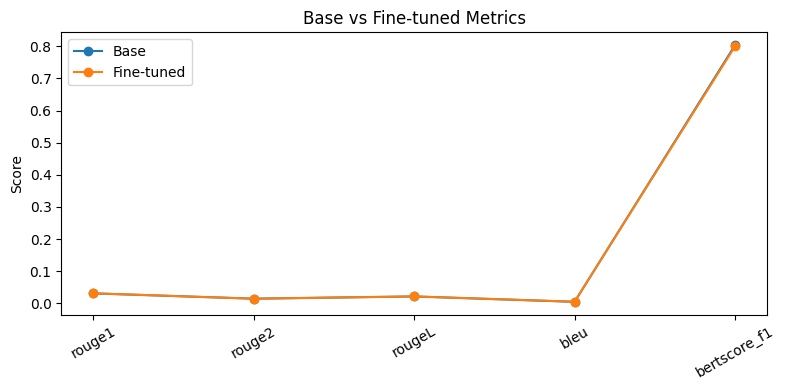

In [5]:
import matplotlib.pyplot as plt

metrics = ["rouge1", "rouge2", "rougeL", "bleu", "bertscore_f1"]

base_vals = [base_scores[m] for m in metrics]
ft_vals   = [ft_scores[m] for m in metrics]

x = range(len(metrics))

plt.figure(figsize=(8,4))
plt.plot(x, base_vals, marker="o", label="Base")
plt.plot(x, ft_vals, marker="o", label="Fine-tuned")
plt.xticks(x, metrics, rotation=30)
plt.ylabel("Score")
plt.title("Base vs Fine-tuned Metrics")
plt.legend()
plt.tight_layout()
plt.show()